# Task 1 - Feature Extraction and Analysis
Please check task1_response.pdf for detailed analysis and explanations

In [20]:
import parselmouth
from parselmouth.praat import call
import csv
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Speech Feature Extraction

## 1. Praat Feature Extraction

In [2]:
WAVE_FILE_DIR = "HW2_wav_files"

In [3]:
def get_num_words(transcript):
    return len(transcript.split())

In [10]:
def extract_speech_features(wave_file, start_time, end_time, num_words, da_tag):
    features = dict()
    features["Target"] = da_tag
    
    try:
        sound = parselmouth.Sound(wave_file).extract_part(from_time=start_time, to_time=end_time)
    except:
        print("File Doesn't Exist")
        return None
    
    # extract pitch
    try:
        pitch = call(sound, "To Pitch", 0.0, 75, 600)
    except:
        pitch = np.NAN

    # extract local jitter
    try: 
        pointProcess = call(sound, "To PointProcess (periodic, cc)", 75, 600)
        features["Jitter"] = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    except:
        features["Jitter"] = np.NAN

    # extract intensity
    try: intensity = call(sound, "To Intensity", 100, 0, "yes")
    except: intensity = np.NAN

    # extract hnr -> first get harmonicity
    try:    
        harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        features["HNR"] = call(harmonicity, "Get mean", 0, 0)
    except:
        features["HNR"] = np.NAN

    # extract local shimmer
    try:
        features["Shimmer"] =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    except:
        features["Shimmer"] = np.NAN

    # extract speacking rate: words/duration
    try:
        duration = call(sound, "Get total duration")
        features["Speaking Rate"] = num_words / duration
    except:
        features["Speaking Rate"] = np.NAN
    
    # pitch min, max, mean, sd
    try:
        features["Min Pitch"] = call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")
        features["Max Pitch"] = call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")
        features["Mean Pitch"] = call(pitch, "Get mean", 0, 0, "Hertz")
        features["Sd Pitch"] = call(pitch, "Get standard deviation", 0, 0, "Hertz")
    except:
        features["Min Pitch"] = np.NAN
        features["Max Pitch"] = np.NAN
        features["Mean Pitch"] = np.NAN
        features["Sd Pitch"] = np.NAN
        

    # intensity min, max, mean, sd
    try:
        features["Min Intensity"] = call(intensity, "Get minimum", 0, 0, "parabolic")
        features["Max Intensity"] = call(intensity, "Get maximum", 0, 0, "parabolic")
        features["Mean Intensity"] = call(intensity, "Get mean", 0, 0, "energy")
        features["Sd Intensity"]= call(intensity, "Get standard deviation", 0, 0)
    except:
        features["Min Intensity"] = np.NAN
        features["Max Intensity"] = np.NAN
        features["Mean Intensity"] = np.NAN
        features["Sd Intensity"]= np.NAN
    
    return features

In [127]:
# read train and test.csv as pandas dataframe
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Some PREPROCESSING
# remove rows with not existing dialog_id wav file
# get list of all wav files
wav_file_list = os.listdir(WAVE_FILE_DIR)
wav_dialog_ids = set([filename[:-6] for filename in wav_file_list])

print(f"Train set size before non existing wav removal: {len(train_df)}")
train_df = train_df[train_df.dialog_id.isin(wav_dialog_ids)]
print(f"Train set size after non existing wav removal: {len(train_df)}")
print()
print(f"Test set size before non existing wav removal: {len(test_df)}")
test_df = test_df[test_df.dialog_id.isin(wav_dialog_ids)]
print(f"Test set size after non existing wav removal: {len(test_df)}")

Train set size before non existing wav removal: 101794
Train set size after non existing wav removal: 91084

Test set size before non existing wav removal: 18579
Test set size after non existing wav removal: 16886


In [128]:
# drop except top 10 extraction efficiency as classification and analysis only require top 10 tags
top_10_tags = ['b', 'sv', 'sd', '%', 'aa', 'ny', 'fc', 'x', 'qy', 'ba']
print(f"Train set size before non top 10 removal: {len(train_df)}")
train_df = train_df[train_df.da_tag.isin(top_10_tags)]
print(f"Train set size after non top 10 removal: {len(train_df)}")
print()
print(f"Test set size before non top 10 removal: {len(test_df)}")
test_df = test_df[test_df.da_tag.isin(top_10_tags)]
print(f"Test set size after non top 10 removal: {len(test_df)}")

# save preprocessed train_df and test_df as .csv files
train_df.to_csv("train_preprocessed.csv")
test_df.to_csv("test_preprocessed.csv")

Train set size before non top 10 removal: 91084
Train set size after non top 10 removal: 77659

Test set size before non top 10 removal: 16886
Test set size after non top 10 removal: 14420


In [11]:
# header
feature_header = [
    'Target',
    'Min Pitch',
    'Max Pitch',
    'Mean Pitch',
    'Sd Pitch',
    'Min Intensity',
    'Max Intensity',
    'Mean Intensity',
    'Sd Intensity',
    'Speaking Rate',
    'Jitter',
    'Shimmer',
    'HNR'
]

with open("train_speech_features.csv", "w") as f:
        writer = csv.DictWriter(f, fieldnames=feature_header)
        writer.writeheader()
        for _, row in tqdm(train_df.iterrows()):
            num_words = get_num_words(row["transcript"])
            file_name = row["dialog_id"] + "_" + row["speaker"] + ".wav"
            file_dir = WAVE_FILE_DIR + "/" + file_name
            start_time = row["start_time"]
            end_time = row["end_time"]
            da_tag = row["da_tag"]
            # print(f"Processing file: {file_name}")
            speech_features = extract_speech_features(file_dir, start_time, end_time, num_words, da_tag)
            if not speech_features:
                continue
            writer.writerow(speech_features)

77659it [4:33:42,  4.73it/s]


In [15]:
# check train data
train_speech_df = pd.read_csv("train_speech_features.csv")
train_speech_df

,Target,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,x,87.138127,172.838418,116.408650,17.341471,13.044169,52.749818,37.469195,9.388077,0.091334,0.013292,0.095146,10.592658
1,x,76.595613,579.072883,112.604750,80.076506,17.813365,45.041444,33.448029,6.838837,0.095963,0.024073,0.111442,6.452603
2,sv,76.264618,581.627307,119.113669,92.760917,13.812498,62.929540,50.496110,14.406085,3.706588,0.026481,0.126959,8.871740
3,b,98.272004,132.748855,107.849507,7.938820,17.841690,61.108041,53.496294,16.190975,1.369783,0.021882,0.110988,10.746552
4,sd,74.692568,125.885080,99.452758,13.524605,13.158364,63.181769,53.527119,14.361831,2.702703,0.019641,0.071869,9.471201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77654,b,93.526161,103.852956,96.713654,2.571987,34.124301,52.473968,48.303112,4.485198,2.433360,0.010574,0.081790,7.892052
77655,x,361.566501,420.509134,393.391275,15.895450,-337.351177,29.352794,20.049973,71.289352,0.379225,0.038753,0.213795,-1.982885
77656,x,90.553734,219.920717,117.732345,31.909327,16.219428,42.411112,33.664570,6.804341,0.435206,0.024254,0.100165,4.835884
77657,b,101.565126,110.380117,103.934516,2.807782,40.392162,43.096970,42.338514,1.029007,8.342947,0.036183,0.122089,5.939803


In [13]:
with open("test_speech_features.csv", "w") as f:
        writer = csv.DictWriter(f, fieldnames=feature_header)
        writer.writeheader()
        for _, row in tqdm(test_df.iterrows()):
            num_words = get_num_words(row["transcript"])
            file_name = row["dialog_id"] + "_" + row["speaker"] + ".wav"
            file_dir = WAVE_FILE_DIR + "/" + file_name
            start_time = row["start_time"]
            end_time = row["end_time"]
            da_tag = row["da_tag"]
            # print(f"Processing file: {file_name}")
            writer.writerow(extract_speech_features(file_dir, start_time, end_time, num_words, da_tag))

14420it [49:12,  4.88it/s]


In [16]:
# check test data
test_speech_df = pd.read_csv("test_speech_features.csv")
test_speech_df

,Target,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,x,NaN,NaN,NaN,NaN,24.601308,51.113381,34.444123,4.310186,0.821535,NaN,NaN,-1.672710
1,x,115.650428,583.174919,267.172220,93.989064,13.309094,47.152107,35.112051,8.246013,0.113376,0.018806,0.133672,10.204328
2,%,115.324126,245.126006,202.997236,30.429153,25.411904,61.641797,53.032828,10.320622,1.609898,0.008007,0.056143,14.189330
3,%,210.529971,273.351323,249.497757,25.240421,29.741415,66.031082,58.446616,9.630219,2.714587,0.014807,0.100135,10.940587
4,sd,166.567822,307.885424,231.524710,37.858472,24.997778,70.622111,60.828510,11.779061,4.097490,0.015224,0.088055,11.078188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14415,ny,95.957200,224.340301,102.280524,22.421901,37.856679,51.471138,48.789622,4.071697,2.478850,0.007252,0.120644,8.111847
14416,sd,88.448651,529.830875,104.203557,31.218828,14.893634,60.321845,53.980989,10.167671,2.630753,0.012267,0.082157,12.952570
14417,x,92.983995,120.491802,106.313061,9.296677,19.503506,41.979913,32.885256,5.328842,0.279068,0.014015,0.166604,1.521949
14418,x,NaN,NaN,NaN,NaN,11.344596,25.391132,17.181176,2.661545,0.451354,NaN,NaN,-3.354832


## 2. Preprocessing

In [286]:
# check for NaN
train_speech_df.isnull().sum()

Target               0
Min Pitch         5952
Max Pitch         5952
Mean Pitch        5952
Sd Pitch          6182
Min Intensity       21
Max Intensity       21
Mean Intensity      21
Sd Intensity        25
Speaking Rate        0
Jitter            6115
Shimmer           6449
HNR                432
dtype: int64

In [287]:
test_speech_df.isnull().sum()

Target               0
Min Pitch         1279
Max Pitch         1279
Mean Pitch        1279
Sd Pitch          1317
Min Intensity        5
Max Intensity        5
Mean Intensity       5
Sd Intensity         6
Speaking Rate        0
Jitter            1310
Shimmer           1375
HNR                 73
dtype: int64

In [288]:
# Fill NaN with average of each column of each class
# make a copy to keep dfs
train_speech_copy = train_speech_df.copy()
test_speech_copy = test_speech_df.copy()

In [289]:
train_speech_copy[train_speech_copy.isnull().any(axis=1)]

,Target,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
169,x,NaN,NaN,NaN,NaN,18.512422,72.291323,48.458670,8.814975,0.213641,NaN,NaN,-12.657090
309,%,NaN,NaN,NaN,NaN,57.790893,63.469656,61.599195,2.013238,7.684981,NaN,NaN,0.570207
385,x,NaN,NaN,NaN,NaN,21.727244,39.268532,35.337751,6.120528,1.782575,NaN,NaN,-3.139077
431,x,91.620482,112.643375,102.131928,14.865430,18.095058,88.917549,70.649495,16.091760,0.468741,0.191012,NaN,2.108548
432,x,77.592555,149.703944,107.819755,37.906019,18.209395,90.904381,72.710436,18.759749,0.549874,0.027685,NaN,2.834476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77615,x,NaN,NaN,NaN,NaN,16.822731,33.021101,27.108959,4.946955,1.351168,NaN,NaN,-2.747051
77618,x,NaN,NaN,NaN,NaN,16.842508,31.211177,25.082070,4.185319,1.643982,NaN,NaN,-3.619067
77624,x,NaN,NaN,NaN,NaN,17.369734,44.005637,32.097570,6.424669,1.125973,NaN,NaN,-2.542490
77631,x,NaN,NaN,NaN,NaN,-335.172000,19.230775,15.614483,137.418708,2.255303,NaN,NaN,-4.158728


In [290]:
test_speech_copy[test_speech_copy.isnull().any(axis=1)]

,Target,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,x,NaN,NaN,NaN,NaN,24.601308,51.113381,34.444123,4.310186,0.821535,NaN,NaN,-1.672710
48,x,NaN,NaN,NaN,NaN,12.552780,26.511861,19.333893,4.059564,3.290090,NaN,NaN,-2.466381
51,x,NaN,NaN,NaN,NaN,26.714604,51.602125,41.168651,5.922481,1.523979,NaN,NaN,-0.072847
148,x,NaN,NaN,NaN,NaN,15.952959,57.194227,41.578010,9.197397,0.913914,NaN,NaN,-1.741002
196,x,NaN,NaN,NaN,NaN,-333.441293,81.867896,61.717848,59.761760,0.442968,NaN,NaN,21.148988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14397,x,NaN,NaN,NaN,NaN,21.804827,33.933534,29.365195,3.460526,1.724710,NaN,NaN,-2.067720
14401,x,NaN,NaN,NaN,NaN,19.804125,36.842118,33.512766,4.062564,1.690912,NaN,NaN,-1.711987
14410,x,NaN,NaN,NaN,NaN,9.097675,33.699633,20.499346,4.739763,0.375101,NaN,NaN,-1.483721
14414,x,NaN,NaN,NaN,NaN,12.238709,22.334042,16.620878,2.390871,2.291633,NaN,NaN,-3.142297


In [291]:
numerical_attrs = feature_header[1:]

for num_attr in numerical_attrs:
    # mean of each target group of a column (num_attr)
    mean = train_speech_copy.groupby("Target")[num_attr].transform("mean")
    check_mean = train_speech_copy.groupby("Target")[num_attr].mean()
    print(num_attr)
    print(check_mean)
    print()
    train_speech_copy[num_attr].fillna(mean, inplace=True)
    
train_speech_clean = train_speech_copy.copy()

Min Pitch
Target
%     125.372112
aa    132.029029
b     134.084943
ba    123.688195
fc    141.717312
ny    142.110328
qy    125.492682
sd    104.309846
sv    104.470128
x     132.129867
Name: Min Pitch, dtype: float64

Max Pitch
Target
%     256.614247
aa    250.617600
b     222.944090
ba    291.741540
fc    295.678394
ny    235.110513
qy    314.050429
sd    333.297347
sv    351.339021
x     326.697468
Name: Max Pitch, dtype: float64

Mean Pitch
Target
%     171.555093
aa    177.667560
b     170.424528
ba    191.349597
fc    201.649203
ny    180.800626
qy    181.377405
sd    165.909333
sv    167.465037
x     194.408196
Name: Mean Pitch, dtype: float64

Sd Pitch
Target
%     39.068051
aa    34.857162
b     26.463183
ba    47.156237
fc    41.263741
ny    30.093948
qy    37.768862
sd    44.920296
sv    48.170850
x     46.648204
Name: Sd Pitch, dtype: float64

Min Intensity
Target
%     22.046782
aa    28.947590
b     26.515675
ba    21.402145
fc    19.262503
ny    27.375098
qy    17.8065

In [292]:
# check sample
train_speech_clean.iloc[169,:]

Target                     x
Min Pitch         132.129867
Max Pitch         326.697468
Mean Pitch        194.408196
Sd Pitch           46.648204
Min Intensity      18.512422
Max Intensity      72.291323
Mean Intensity      48.45867
Sd Intensity        8.814975
Speaking Rate       0.213641
Jitter              0.031171
Shimmer             0.141556
HNR                -12.65709
Name: 169, dtype: object

In [303]:
# drop test set with NaN
# get index for future use in text feature dropping
test_drop_index = test_speech_copy[test_speech_copy.isnull().any(axis=1)].index
test_speech_clean = test_speech_copy.dropna()

In [306]:
test_drop_index

Int64Index([    0,    48,    51,   148,   196,   197,   247,   248,   276,
              307,
            ...
            14364, 14378, 14386, 14390, 14394, 14397, 14401, 14410, 14414,
            14418],
           dtype='int64', length=1391)

In [307]:
# check NaN
train_speech_clean.isnull().sum()

Target            0
Min Pitch         0
Max Pitch         0
Mean Pitch        0
Sd Pitch          0
Min Intensity     0
Max Intensity     0
Mean Intensity    0
Sd Intensity      0
Speaking Rate     0
Jitter            0
Shimmer           0
HNR               0
dtype: int64

In [308]:
test_speech_clean.isnull().sum()

Target            0
Min Pitch         0
Max Pitch         0
Mean Pitch        0
Sd Pitch          0
Min Intensity     0
Max Intensity     0
Mean Intensity    0
Sd Intensity      0
Speaking Rate     0
Jitter            0
Shimmer           0
HNR               0
dtype: int64

In [309]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Scale numerical data
minmax_scaler = MinMaxScaler()

In [310]:
from sklearn.compose import ColumnTransformer

numerical_attrs = feature_header[1:]
all_attrs = numerical_attrs + ["Target"]

preprocessing = ColumnTransformer([("num", minmax_scaler, numerical_attrs)], remainder="passthrough")

train_speech_prepared = pd.DataFrame(preprocessing.fit_transform(train_speech_clean),
                                     columns=all_attrs).convert_dtypes()
train_speech_prepared

,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR,Target
0,0.054081,0.173285,0.080115,0.063913,0.839304,0.901914,0.87632,0.051175,0.000241,0.054151,0.096284,0.376949,x
1,0.03458,0.888478,0.072859,0.295127,0.850429,0.882206,0.865878,0.037279,0.000254,0.098073,0.112775,0.334062,x
2,0.033968,0.892975,0.085276,0.341877,0.841096,0.927942,0.910148,0.078529,0.009962,0.107883,0.128477,0.359122,sv
3,0.074676,0.102706,0.063788,0.029259,0.850495,0.923285,0.917939,0.088259,0.003679,0.089149,0.112315,0.378543,b
4,0.03106,0.090622,0.04777,0.049846,0.83957,0.928587,0.918019,0.078288,0.007263,0.08002,0.072728,0.365332,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77654,0.065897,0.051833,0.042545,0.009479,0.88848,0.901209,0.904453,0.024449,0.006539,0.043077,0.082768,0.348973,b
77655,0.561698,0.60932,0.608495,0.058584,0.0219,0.842093,0.831087,0.388606,0.001015,0.15788,0.216352,0.246676,x
77656,0.060399,0.256175,0.08264,0.117604,0.846711,0.87548,0.866441,0.037091,0.001166,0.098813,0.101363,0.317314,x
77657,0.080767,0.063325,0.056319,0.010348,0.903101,0.877234,0.888965,0.005609,0.022429,0.147411,0.123549,0.328749,b


In [311]:
test_speech_prepared = pd.DataFrame(preprocessing.transform(test_speech_clean),
                                     columns=all_attrs).convert_dtypes()
test_speech_prepared

,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR,Target
0,0.106821,0.895699,0.367716,0.346403,0.839922,0.887602,0.8702,0.04495,0.0003,0.076617,0.13527,0.372926,x
1,0.106217,0.30055,0.245294,0.112149,0.868155,0.924649,0.916735,0.056259,0.004324,0.032621,0.056814,0.414208,%
2,0.282322,0.350242,0.334,0.093025,0.878255,0.935872,0.930793,0.052495,0.007295,0.060325,0.101332,0.380554,%
3,0.201004,0.411041,0.299714,0.13953,0.867189,0.94761,0.936979,0.064209,0.011013,0.062025,0.089108,0.381979,sd
4,0.227033,0.362954,0.303618,0.090538,0.866416,0.943646,0.930021,0.074364,0.008157,0.072661,0.086656,0.391877,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13024,0.033628,0.870418,0.100313,0.261228,0.858059,0.904397,0.880713,0.037246,0.000837,0.119602,0.179026,0.302926,x
13025,0.070394,0.263956,0.053164,0.082637,0.897187,0.898645,0.905717,0.022195,0.006661,0.029544,0.122087,0.35125,ny
13026,0.056505,0.801785,0.056833,0.115059,0.843618,0.921275,0.919197,0.055425,0.007069,0.049977,0.08314,0.401396,sd
13027,0.064894,0.081127,0.060857,0.034264,0.854372,0.874378,0.864417,0.029048,0.000746,0.057097,0.168596,0.282984,x


In [312]:
# save prepared datasets
train_speech_prepared.to_csv("train_speech_prepared.csv")
test_speech_prepared.to_csv("test_speech_prepared.csv")

# Text Feature Extraction

## 1. LIWC Feature Extraction

In [313]:
# will use LIWC feature set given in the train.csv and test.csv
# use train_preprocessed.csv and test_preprocessed.csv where no existing wav file corresponding rows are removed
# and non top 10 dag_tag rows are removed
train_text_df = pd.read_csv("train_preprocessed.csv")
test_text_df = pd.read_csv("test_preprocessed.csv")

In [314]:
train_text_df

,Unnamed: 0,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,1,sw2005,B,SIL,x,0.000000,10.948825,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,3,sw2005,A,SIL,x,10.930126,21.350840,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,4,sw2005,B,well of course it's you know it's one of the l...,sv,10.948825,22.280000,0.642857,0.285714,0.190476,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0
3,5,sw2005,A,yes,b,21.350840,22.080883,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
4,7,sw2005,B,i'd be very very careful and uh you know check...,sd,22.280000,26.720000,0.666667,0.250000,0.250000,...,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77654,101788,sw4936,B,yeah,b,294.023417,294.434372,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
77655,101790,sw4936,B,SIL,x,294.434372,297.071330,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
77656,101791,sw4936,A,SIL,x,296.742236,299.040000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
77657,101792,sw4936,B,yeah,b,297.071330,297.191192,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0


In [315]:
test_text_df

,Unnamed: 0,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,182,sw2022,A,SIL,x,0.000000,1.217234,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,183,sw2022,B,SIL,x,0.000000,8.820205,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,185,sw2022,A,so um,%,1.812709,3.055024,0.500000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0
3,186,sw2022,A,yes,%,3.055024,3.423404,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
4,187,sw2022,A,we do keep uh well we started out keeping a bu...,sd,3.423404,7.084182,0.466667,0.133333,0.133333,...,0.0,0.066667,0.0,0.0,0.133333,0.0,0.0,0.0,0.133333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14415,18574,sw4940,A,yeah,ny,294.596587,295.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
14416,18575,sw4940,B,you can see that horrible horrible brown haze,sd,294.623491,297.664445,0.375000,0.250000,0.125000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
14417,18576,sw4940,A,SIL,x,295.000000,298.583362,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
14418,18577,sw4940,B,SIL,x,297.664445,299.880000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [316]:
# get LIWC features
liwc_cols = list(train_text_df.columns)[7:]
liwc_cols

['function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'article',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'compare',
 'interrog',
 'number',
 'quant',
 'affect',
 'posemo',
 'negemo',
 'anx',
 'anger',
 'sad',
 'social',
 'family',
 'friend',
 'female',
 'male',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certain',
 'differ',
 'percept',
 'see',
 'hear',
 'feel',
 'bio',
 'body',
 'health',
 'sexual',
 'ingest',
 'drives',
 'affiliation',
 'achieve',
 'power',
 'reward',
 'risk',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'relativ',
 'motion',
 'space',
 'time',
 'work',
 'leisure',
 'home',
 'money',
 'relig',
 'death',
 'informal',
 'swear',
 'netspeak',
 'assent',
 'nonflu',
 'filler']

In [317]:
train_text_features = train_text_df.loc[:,liwc_cols]
test_text_features = test_text_df.loc[:,liwc_cols]

In [318]:
# here, I add number of words as a text feature
train_text_features["num_words"] = train_text_df["transcript"].apply(lambda x: len(x.split()))
train_text_features["Target"] = train_text_df["da_tag"]

In [319]:
train_text_features

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,relig,death,informal,swear,netspeak,assent,nonflu,filler,num_words,Target
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
2,0.642857,0.285714,0.190476,0.000000,0.0,0.142857,0.0,0.047619,0.095238,0.047619,...,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,42,sv
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,b
4,0.666667,0.250000,0.250000,0.083333,0.0,0.083333,0.0,0.083333,0.000000,0.000000,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0,12,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77654,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,b
77655,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
77656,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
77657,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,b


In [320]:
test_text_features["num_words"] = test_text_df["transcript"].apply(lambda x: len(x.split()))
test_text_features["Target"] = test_text_df["da_tag"]

In [321]:
test_text_features

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,relig,death,informal,swear,netspeak,assent,nonflu,filler,num_words,Target
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
2,0.500000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,2,%
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,%
4,0.466667,0.133333,0.133333,0.0,0.133333,0.000,0.0,0.000,0.000,0.066667,...,0.0,0.0,0.133333,0.0,0.0,0.0,0.133333,0.0,15,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14415,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,ny
14416,0.375000,0.250000,0.125000,0.0,0.000000,0.125,0.0,0.000,0.125,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,8,sd
14417,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
14418,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x


## 2. Preprocessing

In [322]:
# check NaN
train_text_features.isnull().sum().any()

False

In [323]:
test_text_features.isnull().sum().any()

False

In [325]:
# drop what we dropped in speech features for test set
test_text_features = test_text_features[~test_text_features.index.isin(test_drop_index)]
test_text_features

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,relig,death,informal,swear,netspeak,assent,nonflu,filler,num_words,Target
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
2,0.500000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,2,%
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,%
4,0.466667,0.133333,0.133333,0.0,0.133333,0.000,0.0,0.000,0.000,0.066667,...,0.0,0.0,0.133333,0.0,0.0,0.0,0.133333,0.0,15,sd
5,0.750000,0.125000,0.125000,0.0,0.125000,0.000,0.0,0.000,0.000,0.250000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,8,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14413,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x
14415,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0,1,ny
14416,0.375000,0.250000,0.125000,0.0,0.000000,0.125,0.0,0.000,0.125,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,8,sd
14417,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000,0.000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1,x


In [326]:
# Scale
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

numerical_attrs = list(train_text_features.columns)[:-1]
all_attrs = numerical_attrs + ["Target"]

preprocessing = ColumnTransformer([("num", minmax_scaler, numerical_attrs)], remainder="passthrough")

train_text_prepared = pd.DataFrame(preprocessing.fit_transform(train_text_features),
                                     columns=all_attrs)
train_text_prepared

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,relig,death,informal,swear,netspeak,assent,nonflu,filler,num_words,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
2,0.642857,0.285714,0.190476,0.0,0.0,0.142857,0.0,0.047619,0.095238,0.047619,...,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.539474,sv
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,b
4,0.666667,0.25,0.25,0.083333,0.0,0.083333,0.0,0.083333,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0,0.144737,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,b
77655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
77656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
77657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,b


In [327]:
test_text_prepared = pd.DataFrame(preprocessing.transform(test_text_features),
                                     columns=all_attrs)
test_text_prepared

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,relig,death,informal,swear,netspeak,assent,nonflu,filler,num_words,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.013158,%
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,%
3,0.466667,0.133333,0.133333,0.0,0.133333,0.0,0.0,0.0,0.0,0.066667,...,0.0,0.0,0.133333,0.0,0.0,0.0,0.133333,0.0,0.184211,sd
4,0.75,0.125,0.125,0.0,0.125,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092105,sd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x
13025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,ny
13026,0.375,0.25,0.125,0.0,0.0,0.125,0.0,0.0,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092105,sd
13027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x


In [328]:
# save prepared text features
train_text_prepared.to_csv("train_text_prepared.csv")
test_text_prepared.to_csv("test_text_prepared.csv")

# Feature Description and Analysis

1. Describe your custom feature sets, the reasoning behind choosing them and the techniques used to extract them. Also, include a description of any preprocessing you did.

2. For each custom feature set, formulate and test a hypothesis about one of the features (visually or statistically). Observe if the test results are in accordance with your hypothesis or not. Give a brief explanation about your thinking behind the observed behavior: For example, you might test whether the LIWC feature “tentat” (for ‘tentative’), which is associated with tentative language, or the bigram “I think” are more useful in predicting the dialogue act “Hedge”. This hypothesis could be tested by plotting the normalized frequency of the bigram “I think” and the normalized frequency for the LIWC “tentat” features for the top 10 dialogue act labels and comparing the results.

In [12]:
train_speech_prepared = pd.read_csv("train_speech_prepared.csv", index_col=0)
test_speech_prepared = pd.read_csv("test_speech_prepared.csv", index_col=0)
train_text_prepared = pd.read_csv("train_text_prepared.csv", index_col=0)
test_text_prepared = pd.read_csv("test_text_prepared.csv", index_col=0)

In [13]:
# test if there is a column with all 0
all_zero_count = 0
for col in train_text_prepared.columns:
    if (train_text_prepared[col] == 0).sum() == len(train_text_prepared):
        all_zero_count += 1
        print("column with all zero exist")
if all_zero_count == 0:
    print("No column with all zero values")

No column with all zero values


In [14]:
# so keep all features of LIWC
# all 'might' be helpful

## 2. For each custom feature set, formulate and test a hypothesis about one of the features (visually or statistically)

In [15]:
# speech feature set hypothesis: mean pitch would be useful in predicting the dialogue act
# Because, we can hypothesize or imagine that among top 10 dialogue acts
# there could be noticable difference or order in average pitch amoung different acts 
# for instance, we can think that normally sd (statement-non-opinion) would have lower pitch 
# than that of question acts like qy

In [16]:
# and considering the types of top 10 acts, I think the jitters or hamonicities might be quite similar among the acts, 
# probably except for the non-verbal act like x, which might have a higher average jitter because it includes 
# speech like throat clearing and laughter

In [17]:
# let's test
import matplotlib.pyplot as plt
# first get average mean pitch for each act
average_pitches = train_speech_prepared.groupby("Target")["Mean Pitch"].mean().sort_values().to_frame()
print(average_pitches)
ordered_acts = list(average_pitches.index)

        Mean Pitch
Target            
sd        0.174544
sv        0.177512
b         0.183157
%         0.185314
aa        0.196974
ny        0.202951
qy        0.204051
ba        0.223075
x         0.228909
fc        0.242722


In [21]:
# preprocessing = ColumnTransformer([("num", MinMaxScaler(), ["Mean Pitch"])], remainder="passthrough")
average_pitches_scaled = MinMaxScaler().fit_transform(average_pitches).flatten()
average_pitches_scaled

array([0.        , 0.04352853, 0.12633496, 0.15796812, 0.32899467,
       0.41665773, 0.43279598, 0.71181747, 0.79739694, 1.        ])

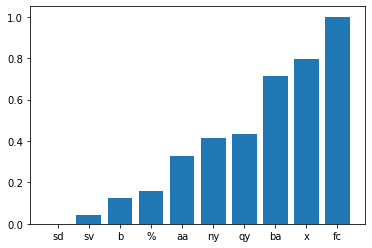

In [22]:
plt.bar(ordered_acts, average_pitches_scaled)
plt.show()

In [23]:
# get average difference
# all diffs
print("Average Difference of all acts:", 1.0/9)

diffs = []
i = 0
while i < 9:
    diff = average_pitches_scaled[i+1] - average_pitches_scaled[i]
    diffs.append(diff)
    i += 1
sorted_diffs = sorted(diffs)
print("Average Difference excluding two largest differences:", np.mean(sorted_diffs[:-2]))

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.07405363526413135


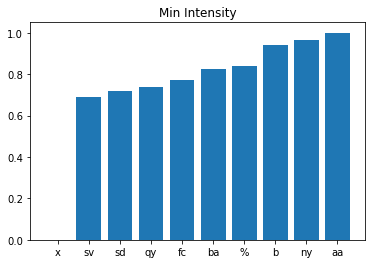

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.029451095107461103



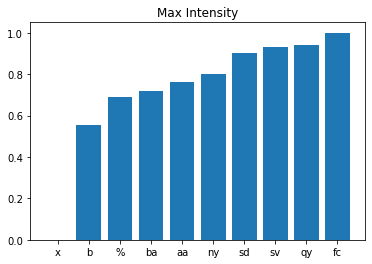

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.04421336419532602



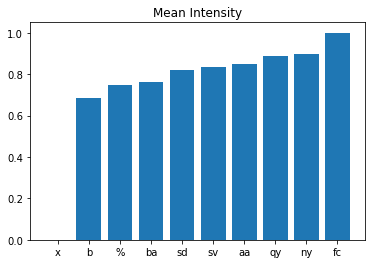

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.029959976198423277



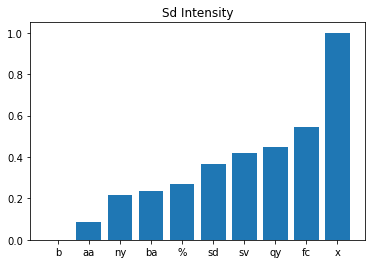

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.05941308814915201



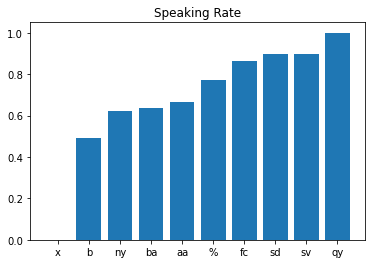

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.054240177543055955



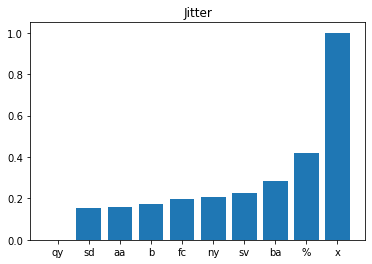

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.03774780292684375



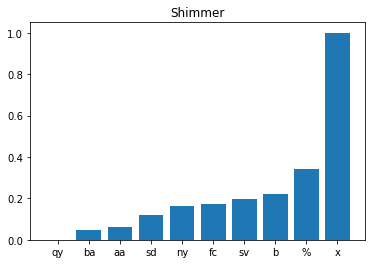

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.031324054178862734



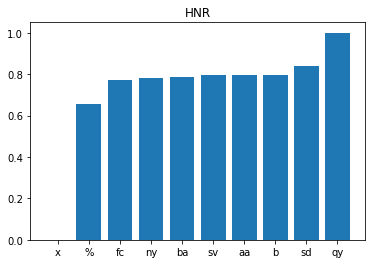

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.02632587688977837



In [25]:
# first get average attr for each act
feature_header = [
    'Target',
    'Min Pitch',
    'Max Pitch',
    'Mean Pitch',
    'Sd Pitch',
    'Min Intensity',
    'Max Intensity',
    'Mean Intensity',
    'Sd Intensity',
    'Speaking Rate',
    'Jitter',
    'Shimmer',
    'HNR'
]
non_pitch_attrs = [attr for attr in feature_header[1:] if "Pitch" not in attr]

for attr in non_pitch_attrs:
    mean = train_speech_prepared.groupby("Target")[attr].mean().sort_values().to_frame()
    # print(mean)
    ordered_acts = list(mean.index)
    mean_scaled = MinMaxScaler().fit_transform(mean).flatten()
    plt.bar(ordered_acts, mean_scaled)
    plt.title(attr)
    plt.show()
    
    print("Average Difference of all acts:", 1.0 / 9)

    diffs = []
    i = 0
    while i < 9:
        diff = mean_scaled[i+1] - mean_scaled[i]
        diffs.append(diff)
        i += 1
    sorted_diffs = sorted(diffs)
    print("Average Difference excluding two largest differences:", np.mean(sorted_diffs[:-2]))
    print()

[(0.15, 0.25)]

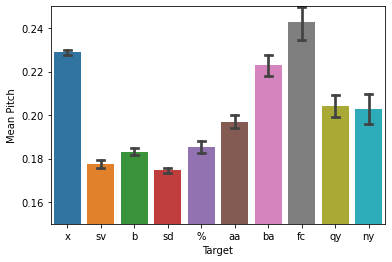

In [233]:
import seaborn as sns
g_pitch = sns.barplot(x="Target", y="Mean Pitch", data=train_speech_prepared, estimator=np.mean, 
            ci=85, capsize=.2)
g_pitch.set(ylim=(0.15, 0.25))

[(0.3, 0.4)]

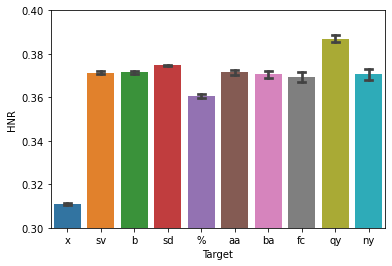

In [206]:
g_hnr = sns.barplot(x="Target", y="HNR", data=train_speech_prepared, estimator=np.mean, 
            ci=85, capsize=.2)
g_hnr.set(ylim=(0.3, 0.4))

[(0.03, 0.13)]

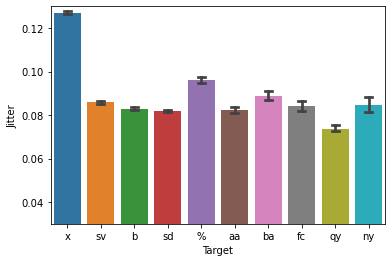

In [226]:
g_jit = sns.barplot(x="Target", y="Jitter", data=train_speech_prepared, estimator=np.mean, 
            ci=85, capsize=.2)
g_jit.set(ylim=(0.03, 0.13))

In [148]:
# check speech features with low variance
from sklearn.feature_selection import VarianceThreshold
speech_features = train_speech_prepared.iloc[:, :-1]

try: 
    feat_selector = VarianceThreshold()
    feat_selector.fit_transform(speech_features)
    print(f"Selected Features: {list(feat_selector.get_feature_names_out)}")
except:
    print(f"No feature in X meets the variance threshold\n")
    print(f"All Features:\n{list(speech_features.columns)}")

No feature in X meets the variance threshold

All Features:
['Min Pitch', 'Max Pitch', 'Mean Pitch', 'Sd Pitch', 'Min Intensity', 'Max Intensity', 'Mean Intensity', 'Sd Intensity', 'Speaking Rate', 'Jitter', 'Shimmer', 'HNR']


In [462]:
# text feature set hypothesis: number of words would be useful in predicting the dialogue act
# Because if we look at the types of top 10 acts, we can imagine each act would be usually longer or shorter 
# than the other ones
# there could be noticable difference in average word counts amoung different acts 
# for instance, we can think that statements would be longer than ba or ny
# and ba would be longer than ny.
# and I think the swear feature might not exist in most acts, 
# probably except for one particular act that usually conveys swear words

4


/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_4688/746520739.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = np.sum(train_text_prepared.std() <= 0.01)


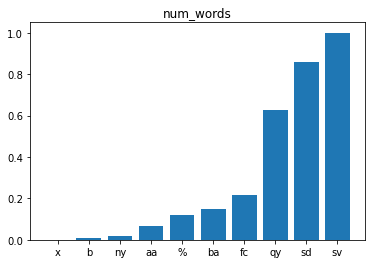

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.05100210020848815

4


/var/folders/c4/dgtyjv595nd6rr69jsl_26m00000gp/T/ipykernel_4688/746520739.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = np.sum(train_text_prepared.std() <= 0.01)


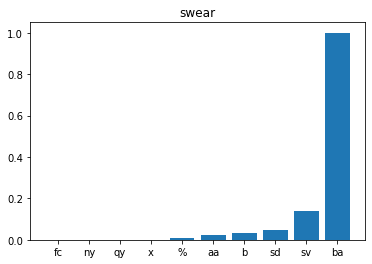

Average Difference of all acts: 0.1111111111111111
Average Difference excluding two largest differences: 0.00675562178185149



In [164]:
for attr in ['num_words','swear']:
    mean = train_text_prepared.groupby("Target")[attr].mean().sort_values().to_frame()
    std = train_text_prepared.std()
    print(std)
    # print(mean)
    ordered_acts = list(mean.index)
    mean_scaled = MinMaxScaler().fit_transform(mean).flatten()
    plt.bar(ordered_acts, mean_scaled)
    plt.title(attr)
    plt.show()

    print("Average Difference of all acts:", 1.0 / 9)

    diffs = []
    i = 0
    while i < 9:
        diff = mean_scaled[i+1] - mean_scaled[i]
        diffs.append(diff)
        i += 1
    sorted_diffs = sorted(diffs)
    print("Average Difference excluding two largest differences:", np.mean(sorted_diffs[:-2]))
    print()

In [96]:
# check text features with low variance
from sklearn.feature_selection import VarianceThreshold
text_features = train_text_prepared.iloc[:, :-1]
text_features.values.shape

(77659, 74)

In [146]:
try: 
    feat_selector = VarianceThreshold(threshold=threshold)
    feat_selector.fit_transform(text_features)
    print(f"Selected Features: {list(feat_selector.get_feature_names_out)}")
except:
    print(f"No feature in X meets the variance threshold\n")
    print(f"All Features:\n{list(text_features.columns)}")
    

No feature in X meets the variance threshold

All Features:
['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'num_words']
